In [1]:
#Universidad Nacional Autónoma de México
#Posgrado en Ciencias de la Tierra 
#Campo 1, geofísica de la Tierra sólida, sismología

#Elaborado por Isaac Valverde, 2022

#Programa 2: Notebook de python 3 que realiza la resolición del ejemplo incluido en (Nocquet, 2018) de un caso sintético usando la estrategia semianalítica que propone así como el método MCMC 
#Referencia: Nocquet, J.-M. (2018). Stochastic static fault slip inversion from geodetic data with non-negativity and bound constraints. Geophysical Journal International, 214 (1), 366–385. 2, 13, 24, 26, 27

#Nota: Debido a que en el muestreo con MCMC se utilizan números pseudoaleatorios, los resultados obtenidos con este método serán distintos con cada corrida

In [2]:
from scipy.stats.mvn import mvnun
import numpy as np
from scipy.stats import norm
from scipy.stats import truncnorm
#from scipy.stats import multivariate_normal as mvn
#import scipy.stats as stats
import matplotlib.pyplot as plt
import time

In [3]:
#Función que evalúa una pdf normal bidimensional de los residuos (verosimilitud)
#Entradas
#m1: 
#m2: 
#G: Arreglo numpy (Matriz de (número de datos)x(número de parámetros) que corresponde al kernel de la inversión).
#d: Arreglo numpy (vector columna) que contiene las observaciones.
#Cdinv: Arreglo numpy que corresponde a la inversa de la matriz de covarianza de los datos.
#Kd: Factor de normalización para la pdf normal correspondiente a la verosimilitud.
#Salida
#sigmlk: Logaritmo natural de la muestra de la verosimilitud.

def likelihood(m1,m2,G,d,Cdinv,Kd):
    #Se obtiene el producto de G por m (datos calculados a partir del modelo directo)
    Gm=np.matmul(G,np.array([[m1],[m2]]))
    sigmlk0=Kd*np.exp(-0.5*np.matmul(np.matmul(np.transpose(Gm-d),Cdinv),(Gm-d)))
    #Se obtiene el logaritmo natural de la muestra
    sigmlk=np.log(sigmlk0[0])
    return sigmlk

In [4]:
#Función que evalúa una pdf normal bidimensional para los parámetros (apriori)
#Entradas
#m1: 
#m2:
#m0:
#Cminv:
#Km:
#Salida
#ln_prior_val: Logaritmo natural de la muestra de la apriori.

def apriori(m1,m2,m0,Cminv,Km):
    #Se construye un arreglo numpy con los parámetros 
    m=np.array([[m1],[m2]])
    sigmap0=Km*np.exp(-0.5*np.matmul(np.matmul(np.transpose(m-m0),Cminv),(m-m0)))
    #Se obtiene el logaritmo natural de la muestra
    sigmap=np.log(sigmap0[0])
    return sigmap

In [5]:
#Función que obtiene una muestra de una pdf posterior calculada a partir de la apriori y la verosimilitud usando el teorema de Bayes
#Entradas
#parametros: Arreglo numpy que contiene los dos parámetros del modelo de una recta [pendiente, ordenada al origen].
#Salida
#lnprob: Muestra de la posterior.

def posterior(m1,m2,G,d,m0,Cdinv,Cminv,Kd,Km):
    lnlk=likelihood(m1,m2,G,d,Cdinv,Kd)
    lnp=apriori(m1,m2,m0,Cminv,Km)
    lnposterior=lnlk+lnp
    return lnposterior

In [6]:
#Cálculo de la medía
def TNmean(a,b,m,sd,ndx=10000):
    ai=a
    bi=b
    xi=np.linspace(ai,bi,ndx)
    fi=(norm.pdf((xi-m)/sd)/(norm.cdf((bi-m)/sd)-norm.cdf((ai-m)/sd)))*(1/sd)
    I=np.trapz(fi*xi,x=xi,dx=(xi[1]-xi[0]))
    return I

In [7]:
def TNvar(a,b,m,sd,ndx=10000):
    ai=a
    bi=b
    xi=np.linspace(ai,bi,ndx)
    fi=(norm.pdf((xi-m)/sd)/(norm.cdf((bi-m)/sd)-norm.cdf((ai-m)/sd)))*(1/sd)
    I=np.trapz(fi*(xi-TNmean(a,b,m,sd,ndx))**2,x=xi,dx=(xi[1]-xi[0]))
    return I

In [8]:
def CV(a,b,m,sd,ndx=10000):
    Ans=np.zeros([len(m)])
    for i in range(0, len(m)):
        mean=TNmean(a,b,m[i],sd[i],ndx)
        std=(TNvar(a,b,m[i],sd[i],ndx))**(0.5)
        Ans[i]=(std/mean)*100
    return Ans

In [9]:
#------------------------Datos Nocquet------------------------

#Se define el número de datos 
Nd=3
#Se define el número de parámetros
Nm=2
#Se define la matriz que relaciona los datos con los parámetros (kernel?) 
G=np.array([[-7,-4],[1,10],[2,-11]])
#Se define la transpuesta de la matriz G
GT=np.transpose(G)
#Se define el vector de datos
d=np.array([[10],[3],[-5]])
#Se define la matriz de covarianza de los datos
Cd=(5**2)*np.identity(Nd)

In [10]:
#------------------------Espacio de parámetros------------------------

#Se define el límite inferior de cada parámetro
a1=0
a2=0
#Se define un vector columna con el límite inferior de cada parámetro
a=np.array([[a1],[a2]])
#Se define el límite superior de cada parámetro
b1=1
b2=1
#Se define un vector columna con el límite superior de cada parámetro
b=np.array([[b1],[b2]])
#Se define el espacio de parámetros (m1 y m2)
m1=np.linspace(a1, b1, num=500)
m2=np.linspace(a2, b2, num=500)
#Se define una malla para el dominio del espacio de parámetros
M1,M2=np.meshgrid(m1, m2)
#Se define un vector con la media de los parámetros (pp 372, primer parrafo, tercer renglón)
m0=np.array([[b1/2],[b2/2]])
#Se define un valor de la constante "alpha" para la aproximación
alpha=8
#Se define la desviación estandar (pp 373, primer párrafo, quinto renglón)
sigma=alpha*(b1/2)
#Se define la matriz de covarianza de los parámetros (pp) (pp 372, primer parrafo, segundo renglón)
Cm=(sigma**2)*np.identity(2)

In [11]:
#Se toma un tiempo de inicio para medir el tiempo de ejecución de la estrategia semianalítica (primera parte)
start_sa1=time.perf_counter()

#Se define la inversa de la matriz de covariana de los datos (Matriz de precisión) 
Cdinv=np.linalg.inv(Cd)
#Se define la inversa la matriz de covarianza de los parámetros
Cminv=np.linalg.inv(Cm)

#------------------------Expectativa y matriz de covarianza posterior------------------------

#Se define la matriz de covarianza posterior (Ecuaciones de Tarantola y Valette, pp. 369, Ec. 7)
Cmv=np.linalg.inv(np.matmul(np.matmul(GT,Cdinv),G)+Cminv)
#Se define la transpuesta de la matriz de covarianza posterior
CmvT=np.transpose(Cmv)
#Se define la inversa de la matriz de covarianza posterior
Cmvinv=np.matmul(np.matmul(GT,Cdinv),G)+Cminv
#Se define la expectativa (Ecuaciones de Tarantola y Valette, pp. 369, Ec. 6)
mv=np.matmul(np.linalg.inv(np.matmul(np.matmul(GT,Cdinv),G)+Cminv), np.matmul(np.matmul(GT,Cdinv),d)+np.matmul(Cminv,m0))

#------------------------Integral de exp(-S(m))------------------------

#Se hace el cálculo de la integral (Para la exprensión en función de la expectativa y la matriz de covarianza posterior)
I=mvnun(a,b,mv,Cmv)
#Se obtiene el factor de normalización de la distribución normal
Inorm=1/((np.linalg.det(Cmv))*(2*np.pi)**(Nm))**(0.5)
#Se define el término que corresponde a la multiplicación de la matriz G con el vector m0
Gm0=np.matmul(G,m0)
#Se define el factor K0 para el calculo de las marginales (pag. 369, segundo parrafo, primer renglón)
K0=np.matmul(np.matmul(np.transpose(Gm0-d),np.linalg.inv(np.matmul(np.matmul(G,Cm),GT)+Cd)),(Gm0-d))
#Se define el factor de normalización kb (definido bajo la ecuación 5, pag. 368) (La exponencial de -Ko/2 viene de calcular la integral usando la forma de obtener S(m) mostrada en el apendice B1)
kb=(Inorm)/(I[0]*np.exp(-K0/2))
#Se define un parámetro Kb para el cálculo de las marginales para los parámetros m1 y m2 (definido bajo la ecuación 9, pag. 369)
Kb=kb*np.exp(-K0/2)

#Se toma el tiempo final para medir el tiempo de ejecución de la estrategia semianalítica (primera parte)
end_sa1=time.perf_counter()
#Se calcula el tiempo de ejecución de la estrategia semianalítica (primera parte) 
t_sa1=end_sa1-start_sa1

In [12]:
#--------------Cálculo de la PDF posterior conjunta--------------

#Se define un arreglo para la posterior
sigmMb=np.zeros([len(m1),len(m2)])

#Se toma un tiempo de inicio para medir el tiempo de ejecución de la estrategia semianalítica (segunda parte, PDF posterior conjunta)
start_sa2=time.perf_counter()

for i in range(0,len(m1)):
    for j in range (0,len(m2)):
        #Cálculo de la posterior (ecuación 9, pag. 369) 
        sigmMb[j,i]=Kb*np.exp(-0.5*np.matmul(np.matmul(np.transpose(np.array([[m1[i]],[m2[j]]])-mv),Cmvinv),(np.array([[m1[i]],[m2[j]]])-mv)))
        
#Se toma el tiempo final para medir el tiempo de ejecución de la estrategia semianalítica (segunda parte)
end_sa2=time.perf_counter()
#Se calcula el tiempo de ejecución de la estrategia semianalítica (segunda parte)
t_sa2=end_sa2-start_sa2
        

In [13]:
#--------------Marginales (figuras g y h)--------------

#Se define un arreglo para la marginal del parámetro 1
sigmMb1=np.zeros([1,len(m1)])
#Se define un arreglo para la marginal del parámetro 2
sigmMb2=np.zeros([1,len(m2)])

#Se toma un tiempo de inicio para medir el tiempo de ejecución de la estrategia semianalítica (tercera parte, PDFs posteriores marginales)
start_sa3=time.perf_counter()

#Se define el parámetro "A" para el cálculo de la marginal de m1 (pagina 369, tercera ecuación bajo la ecuación 10)
#A1=Cmv[1,1]-CmvT[0,1]*Cmvinv[0,0]*Cmv[0,1]
A1=Cmv[1,1]-CmvT[0,1]*(1/Cmv[0,0])*Cmv[0,1]
#Se define el parámetro "A" para el cálculo de la marginal de m2 (desarrollo realizado en la bitácora y definido como "B")
A2=Cmv[0,0]-Cmv[0,1]*(1/Cmv[1,1])*CmvT[0,1]

for i in range(0,len(m1)):
    #Se obtiene el valor de la media para la marginal m1 (pagina 369, cuarta ecuación bajo la ecuación 10) 
    bm1=mv[1][0]+(CmvT[0,1]*(1/Cmv[0,0])*(m1[i]-mv[0][0]))
    #Calculo del factor de normalización para la integral de la distribución normal para m1
    Inormsig1=1/(A1*2*np.pi)**(0.5)
    #Se obtiene el valor de la integral para la marginal de m1 
    Isig1=mvnun(a1,b1,bm1,A1)
    #Se obtiene la marginal para el parámetro 1 (ecuación 11, pag 369)
    sigmMb1[0][i]=Kb[0][0]*np.exp(-0.5*np.transpose(m1[i]-mv[0][0])*(1/Cmv[0,0])*(m1[i]-mv[0][0]))*(Isig1[0]/Inormsig1)
    
    #Se obtiene el valor de la media para la marginal m2 (desarrollo realizado en la bitácora)
    bm2=mv[0][0]+(Cmv[0,1]*(1/Cmv[1,1])*(m2[i]-mv[1][0]))
    #Calculo del factor de normalización para la integral de la distribución normal para m2
    Inormsig2=1/(A2*2*np.pi)**(0.5)
    #Se obtiene el valor de la integral para la marginal de m2 
    Isig2=mvnun(a2,b2,bm2,A2)   
    #Se obtiene la marginal para el parámetro 2
    sigmMb2[0][i]=Kb[0][0]*np.exp(-0.5*np.transpose(m2[i]-mv[1][0])*(1/Cmv[1,1])*(m2[i]-mv[1][0]))*(Isig2[0]/Inormsig2)
        

        
#Se toma el tiempo final para medir el tiempo de ejecución de la estrategia semianalítica (tercera parte)
end_sa3=time.perf_counter()
#Se calcula el tiempo de ejecución de la estrategia semianalítica (tercera parte)
t_sa3=end_sa3-start_sa3

In [14]:
print("Tiempo de ejecución estrategia semianalítica 1:",t_sa1)
print("Tiempo de ejecución estrategia semianalítica 2:",t_sa2)
print("Tiempo de ejecución estrategia semianalítica 3:",t_sa3)
print("Tiempo de ejecución estrategia semianalítica:",t_sa1+t_sa2+t_sa3)

Tiempo de ejecución estrategia semianalítica 1: 0.4482092869993721
Tiempo de ejecución estrategia semianalítica 2: 5.360504137999669
Tiempo de ejecución estrategia semianalítica 3: 0.0256269040000916
Tiempo de ejecución estrategia semianalítica: 5.834340328999133


In [15]:
#Se comprueba que la PDF posterior sea una distribución de probabilidad, integrando y buscando obtener un volumen cercano a 1

#Se define un delta de área
dm=(m1[1]-m1[0])**(2)
#Se define una variable auxiliar para sumar el volumen de cada paralelepipedo
aux=0
#Se define un ciclo para recorrer los paralelepipedos de la PDF posterior
for i in range(0,len(m1)-1):
    for j in range (0,len(m2)-1):
        aux=aux+(dm*sigmMb[j,i])

#Se muestra el resultado de la integral        
print(aux)


1.0052316098864498


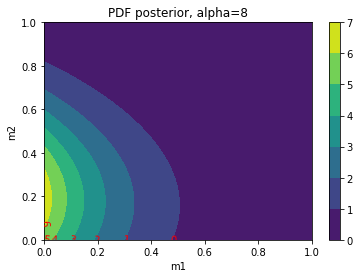

In [16]:
#--------------Gráfica de la PDF posterior conjunta--------------

c=plt.contourf(M1,M2,sigmMb)
plt.clabel(c,fontsize=10,colors='red',inline=True)
plt.contourf(M1,M2,sigmMb)
plt.xlabel("m1")
plt.ylabel("m2")
plt.title("PDF posterior, alpha="+str(alpha))
plt.colorbar()
plt.show()

In [17]:
#Se comprueba que las PDF marginales sean distribuciones de probabilidad, integrando y buscando obtener un volumen cercano a 1

#Se muestra la integral de la marginal para el parámetro m1
print(np.trapz(sigmMb1,x=m1,dx=(m1[1]-m1[0])))
#Se muestra la integral de la marginal para el parámetro m2
print(np.trapz(sigmMb2,x=m2,dx=(m2[1]-m2[0])))

[1.00000408]
[0.99999897]


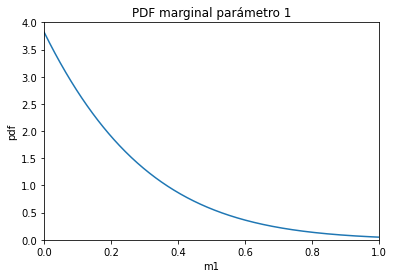

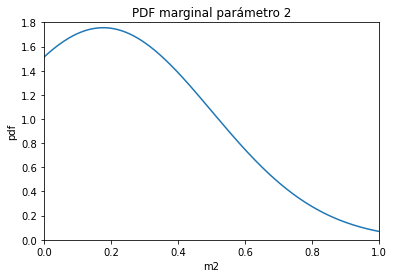

In [18]:
#--------------Gráficas de las Marginales--------------

plt.plot(m1,sigmMb1[0])
plt.xlim(0,1)
plt.ylim(0,4)
plt.xlabel("m1")
plt.ylabel("pdf")
plt.title("PDF marginal parámetro 1")
plt.show()

plt.plot(m2,sigmMb2[0])
plt.xlim(0,1)
plt.ylim(0,1.8)
plt.xlabel("m2")
plt.ylabel("pdf")
plt.title("PDF marginal parámetro 2")
plt.show()

In [19]:
#------------------------------------Resolucion usando MCMC------------------------------------

In [20]:
np.random.seed(seed=233423)
#Se define una propuesta inicial [parámetro 1, parámetro 2]
p0=[0.5,0.5]
#La propuesta se convierte de una lista a un objeto numpy array
p0=np.array(p0)
#Se define un número de repeticiondes del MCMC
Nc=5*(10**5)
#Se define un arreglo para los datos generados con el muestreo
MCMC=np.zeros([Nc, len(p0)]) 
#Se define un arreglo para las muestras de la posterior
ln_probs = np.zeros(Nc) 

#Se asigna la primer propuesta el primer elemento de la cadena 
MCMC[0]=p0  

#Se toma un tiempo de inicio para medir el tiempo de ejecución con el método MCMC 
start_MCMC=time.perf_counter()
#Factor de normalización para la verosimilitud
Kd=1/((np.linalg.det(Cd))*(2*np.pi)**(Nm))**(0.5)
#Factor de normalización para la apriori
Km=1/((np.linalg.det(Cm))*(2*np.pi)**(Nm))**(0.5)

#Se define la primer muestra de la posterior a partir de la primer propuesta para los parámetros
ln_probs[0]=posterior(p0[0],p0[1],G,d,m0,Cdinv,Cminv,Kd,Km)
    
#Cíclo que realiza el muestreo con MCMC
for i in range(1,Nc):
    #Se calculan las perturbaciones para los parámetros extraidas de distribuciones normales truncadas a manera de obtener únicamente muestras dentro del espacio paramétrico.    
    pertm1=truncnorm.rvs(-(MCMC[i-1,0]-a1),b1-MCMC[i-1,0],loc=0, scale=1) 
    pertm2=truncnorm.rvs(-(MCMC[i-1,1]-a2),b2-MCMC[i-1,1],loc=0, scale=1) 
    #Las perturbaciones para ambos parámetros se introducen en un arreglo numpy
    pert=np.array([pertm1,pertm2])
    #Se perturban los parámetros
    propuesta=MCMC[i-1]+pert
    #Se obtiene la distribución posterior de los parámetros perturbados
    Newlnprob=posterior(propuesta[0],propuesta[1],G,d,m0,Cdinv,Cminv,Kd,Km)
    #Se obtiene la relación entre los parámetros perturbados y los de la iteración anterior
    Ratiolnprob=Newlnprob-ln_probs[i-1]
    #Criterio de metrópolis
    if (Ratiolnprob > 0) or (Ratiolnprob > np.log(np.random.uniform())):
        MCMC[i] = propuesta
        ln_probs[i] = Newlnprob
    else:
        MCMC[i]=MCMC[i-1]
        ln_probs[i]=ln_probs[i-1]

#Se toma el tiempo final para medir el tiempo de ejecución con el método MCMC 
end_MCMC=time.perf_counter()
#Se calcula el tiempo de ejecución con el método MCMC
t_MCMC=end_MCMC-start_MCMC

In [21]:
#Se muestra el tiempo de ejecución empleando el método MCMC
print("Tiempo de ejecución MCMC:",t_MCMC)

Tiempo de ejecución MCMC: 309.2870370689998


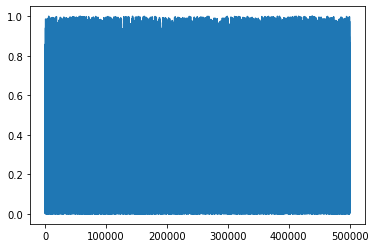

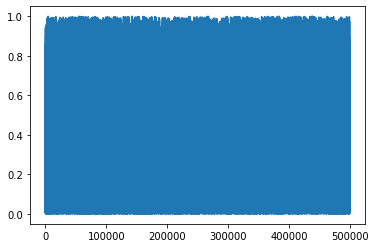

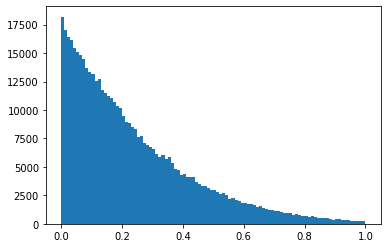

In [22]:
plt.plot(MCMC[:,0],label="Muestras de la cadena")
plt.show()


MCMC1=MCMC[1000:]

plt.plot(MCMC1[:,0],label="Muestras de la cadena")
plt.show()

plt.hist(MCMC1[:,0],bins=100)
plt.show()

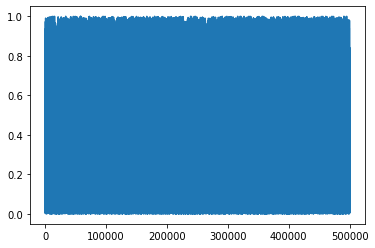

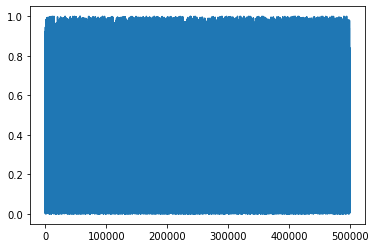

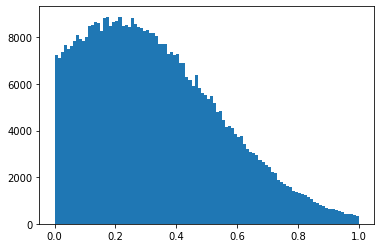

In [23]:
plt.plot(MCMC[:,1],label="Muestras de la cadena")
plt.show()


MCMC1=MCMC[1000:]

plt.plot(MCMC1[:,1],label="Muestras de la cadena")
plt.show()


plt.hist(MCMC1[:,1],bins=100)
plt.show()

In [24]:
#Se define una discretización del rango de valores para el primer parámetro
#m1d=np.arange(np.min(MCMC1[:,0]),np.max(MCMC1[:,0]),0.05)
m1d=np.arange(a1,b1,0.05)
#Se define una discretización del rango de valores para el segundo parámetro
#m2d=np.arange(np.min(MCMC1[:,1]),np.max(MCMC1[:,1]),0.05)
m2d=np.arange(a2,b2,0.05)
M1d,M2d=np.meshgrid(m1d, m2d)


In [25]:
SigmaMCMC=np.zeros((len(m1d),len(m2d)))

start_malla=time.perf_counter()

for i in range(0,len(m1d)-1):
    for j in range(0,len(m2d)-1):
        for k in range(0,len(MCMC[:,1])):
            if (MCMC[k,0]>=m1d[i] and MCMC[k,0]<m1d[i+1] and MCMC[k,1]>=m2d[j] and MCMC[k,1]<m2d[j+1]):
                SigmaMCMC[i,j]=SigmaMCMC[i,j]+1
                np.delete(MCMC, k, axis=0)
                
end_malla=time.perf_counter()

t_malla=end_malla-start_malla

In [26]:
print("Tiempo de ejecución para la malla:",t_malla)

Tiempo de ejecución para la malla: 933.1135350639997


In [27]:
dA=((m1d[1]-m1d[0])*(m2d[1]-m2d[0]))
dl1=m1d[1]-m1d[0]
dl2=m2d[1]-m2d[0]
SigmaMCMC=SigmaMCMC*dA
norm_factor=np.sum(SigmaMCMC)
SigmaMCMC=SigmaMCMC/norm_factor/dA
print(np.sum(SigmaMCMC)*dA)

0.9999999999999999


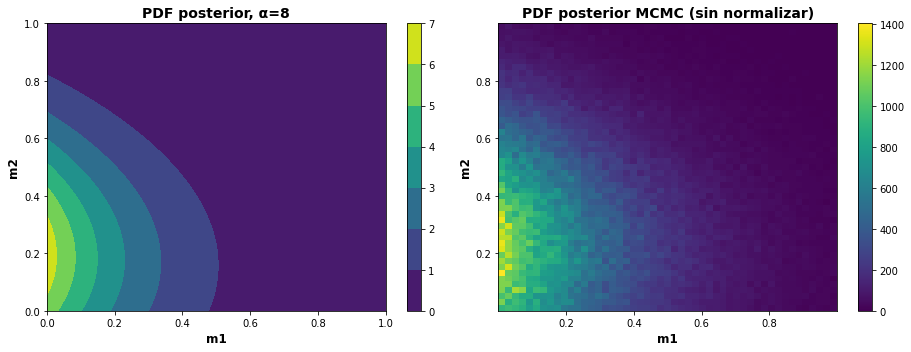

In [28]:
m1_bins=np.linspace(np.min(MCMC[:,0]), np.max(MCMC[:,0]), 50) 
m2_bins=np.linspace(np.min(MCMC[:,1]), np.max(MCMC[:,1]), 50) 

fig, axs = plt.subplots(1, 2,figsize=(13, 5))
f1=axs[0].contourf(M1,M2,sigmMb)
axs[0].set_ylabel("m2",fontsize=12,fontweight=600)
axs[0].set_xlabel("m1",fontsize=12,fontweight=600)
axs[0].set_title("PDF posterior, α="+str(alpha),fontsize=14,fontweight=600)
fig.colorbar(f1, ax=axs[0])

f2=axs[1].hist2d(MCMC[:,0], MCMC[:,1],bins =[m1_bins, m2_bins]) 
axs[1].set_ylabel("m2",fontsize=12,fontweight=600)
axs[1].set_xlabel("m1",fontsize=12,fontweight=600)
axs[1].set_title("PDF posterior MCMC (sin normalizar)", fontsize=14, fontweight=550)

fig.colorbar(f2[3], ax=axs[1])
plt.tight_layout()

#plt.savefig("PDF_Conj_sintetico.png",dpi=400,bbox_inches='tight')

plt.show()


0.9999999999999999
0.9999999999999999


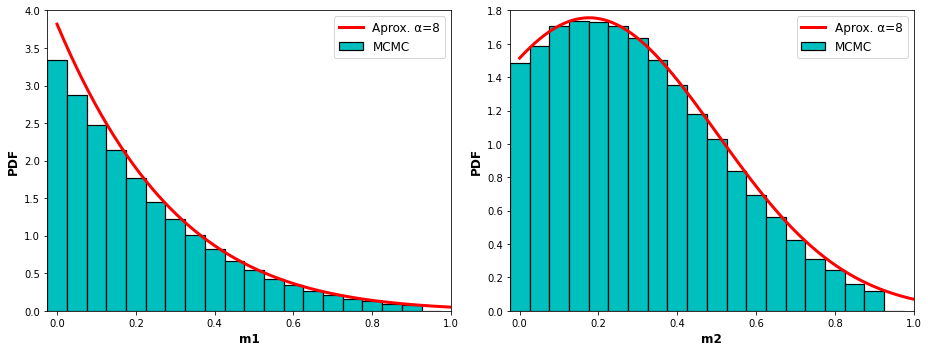

In [29]:
SigMarg1=np.sum((SigmaMCMC)*dl2,axis=1)
print(np.sum(SigMarg1*dl1))

SigMarg2=np.sum((SigmaMCMC)*dl1,axis=0)
print(np.sum(SigMarg2*dl2))

fig, axs = plt.subplots(1, 2,figsize=(13, 5))
axs[0].bar(m1d,SigMarg1,width=0.05,edgecolor="k",color="c",linewidth=1.2,label="MCMC")
axs[0].plot(m1,sigmMb1[0],color="r",label="Aprox. α=8",linewidth=3)
axs[0].set_xlim([-0.025,1])
axs[0].set_ylim([0,4])
axs[0].set_ylabel("PDF",fontsize=12,fontweight=600)
axs[0].set_xlabel("m1",fontsize=12,fontweight=600)
axs[0].legend(prop={'size': 12})

axs[1].bar(m2d,SigMarg2,width=0.05,edgecolor="k",color="c",linewidth=1.2,label="MCMC")
axs[1].plot(m2,sigmMb2[0],color="r",label="Aprox. α=8",linewidth=3)
axs[1].set_xlim([-0.025,1])
axs[1].set_ylim([0,1.8])
axs[1].set_ylabel("PDF",fontsize=12,fontweight=600)
axs[1].set_xlabel("m2",fontsize=12,fontweight=600)
axs[1].legend(prop={'size': 12})

plt.tight_layout()
#plt.savefig("PDF_marg_sintetico.png",dpi=400,bbox_inches='tight')
plt.show()


In [30]:
#
MediaPDF=np.trapz(sigmMb1[0]*m1,x=m1,dx=(m1[1]-m1[0]))
#
VarPDF=np.trapz(sigmMb1[0]*(m1-MediaPDF)**2,x=m1,dx=(m1[1]-m1[0]))
print(round(MediaPDF,3))
print(round(VarPDF**(0.5),3))

0.229
0.2


In [31]:
#
MediaPDF1=np.trapz(sigmMb2[0]*m2,x=m2,dx=(m2[1]-m2[0]))
#
VarPDF1=np.trapz(sigmMb2[0]*(m2-MediaPDF1)**2,x=m2,dx=(m2[1]-m2[0]))
print(round(MediaPDF1,3))
print(round(VarPDF1**(0.5),3))

0.328
0.219


In [32]:
#Estadísticas Nocquet

print("        m1","     m2")
print("Media",round(MediaPDF,3),"/",round(MediaPDF1,3))
#Para m2
print("Std  ",round(VarPDF**(0.5),3),"/",round(VarPDF1**(0.5),3))

        m1      m2
Media 0.229 / 0.328
Std   0.2 / 0.219


In [33]:
MediaPDF_MCMC=np.trapz(SigMarg1*m1d,x=m1d,dx=(m1d[1]-m1d[0]))
VarPDF_MCMC=np.trapz(SigMarg1*(m1d-MediaPDF_MCMC)**2,x=m1d,dx=(m1d[1]-m1d[0]))
print(round(MediaPDF_MCMC,3))
print(round(VarPDF_MCMC**(0.5),3))

0.208
0.187


In [34]:
MediaPDF_MCMC2=np.trapz(SigMarg2*m2d,x=m2d,dx=(m2d[1]-m2d[0]))
VarPDF_MCMC2=np.trapz(SigMarg2*(m2d-MediaPDF_MCMC2)**2,x=m2d,dx=(m2d[1]-m2d[0]))
print(round(MediaPDF_MCMC2,3))
print(round(VarPDF_MCMC2**(0.5),3))

0.305
0.205


In [42]:
np.savetxt('MCMC_p2.txt', MCMC)
np.savetxt('Sigma_MCMC_p2.txt', SigmaMCMC)

In [35]:

TNmean(a1,b1,mv[0],(Cmv[0,0])**(0.5))

0.23323502832557985

In [24]:
def reorder(A,ind):
    n1,n2=np.shape(A)
    aux1=np.zeros((len(ind),n2))
    aux2=np.copy(A)
    for i in range (0,len(ind)):
        aux1[i]=np.copy(A[ind[i]-1])
        aux2=np.delete(A,ind-1,axis=0)
    A1=np.concatenate((aux1, aux2), axis=0)
    return A1

In [26]:
def product(*args, repeat=1):
    # product('ABCD', 'xy') --> Ax Ay Bx By Cx Cy Dx Dy
    # product(range(2), repeat=3) --> 000 001 010 011 100 101 110 111
    pools = [tuple(pool) for pool in args] * repeat
    result = [[]]
    for pool in pools:
        result = [x+[y] for x in result for y in pool]    
    for prod in result:
        yield tuple(prod)

In [40]:
#Funcion que calcula las marginales de una distribución de probabilidad (caso general)
def PDFmarginal(x,m,Cmv1,mv1,Kb,Ind1):  
    
    #Se obtiene una lista con todas las posibles combinaciones del espacio de parámetros
    Ind=np.array(Ind1)
    #Se acomodan las filas y la columnas de la matriz de covarianza posterior de los parámetros en función de la marginal requerida
    Cmv0=np.transpose(reorder(np.transpose(Cmv1),Ind))
    Cmv=reorder(Cmv0,Ind)
    #Se acomodan los elementos del vector expectativa en función de la marginal requerida
    mv=reorder(mv1,Ind)
    
    NmM=len(Ind)
    Nm=np.shape(m)[1]
    mn=m[0:len(m),0]
    
    #Se definen las submatrices necesarias para las operaciones del calculo de las marginales
    Cmvinv11=np.linalg.inv(np.array([Cmv[0:NmM,0:NmM]]).reshape(NmM,NmM))
    print(Cmvinv11)
    Cmv21=Cmv[NmM:Nm,0:NmM].reshape(Nm-NmM,NmM)
    CmvT21=np.transpose(Cmv21).reshape(NmM,Nm-NmM)
    Cmv12=Cmv[0:NmM,NmM:Nm].reshape(NmM,Nm-NmM)
    CmvT12=np.transpose(Cmv12).reshape(Nm-NmM,NmM)
    Cmv22=Cmv[NmM:Nm,NmM:Nm]
    
    mv1=mv[0:NmM,0].reshape(NmM,1)
    mv2=mv[NmM:len(mv),0].reshape(Nm-NmM,1)
    m1=m[:,0:NmM]
    
    #Se obtiene una lista con todas las posibles combinaciones del espacio de parámetros
    indexM=list(product(list(range(0,len(mn))), repeat=NmM))
    
    A=Cmv22-np.matmul(CmvT12,np.matmul(Cmvinv11,Cmv12))
    #Se define un contador para recorrer las combinaciones posibles del espacio de parámetros
    cont=0
    #Se define un arreglo para almacenar los datos de la marginal
    sigmMb1=np.zeros((1,len(x)))
    
    for i in range(0,len(x)):
        b=mv2+np.matmul(CmvT12,np.matmul(Cmvinv11,x[i]-mv1))
        Inormsig1=1/(np.linalg.det(A)*(2*np.pi)**(Nm-NmM))**(0.5)
        Isig1=mvnun(m[0,NmM:Nm].reshape(Nm-NmM,1),m[len(mn)-1,NmM:Nm].reshape(Nm-NmM,1), b, A)
        sigmMb1[0,i]=Kb[0][0]*np.exp(-0.5*np.matmul(np.transpose(x[i]-mv1),np.matmul(Cmvinv11,x[i]-mv1)))*(Isig1[0]/Inormsig1)
        
    
    return(sigmMb1)

In [41]:
m=np.zeros((len(m1),Nm))+m1.reshape(len(m1),1)
xmar=np.linspace(0,1,500)
R1=PDFmarginal(xmar,m,Cmv,mv,Kb,[1])
R2=PDFmarginal(xmar,m,Cmv,mv,Kb,[0])
#R1
#plt.plot(R1[0])
#plt.show()

[[2.17957624]]
[[9.35820304]]


In [28]:
MediaPDF=np.trapz(R1[0]*xmar,x=xmar,dx=(xmar[1]-xmar[0]))
VarPDF=np.trapz(R1[0]*(xmar-MediaPDF)**2,x=xmar,dx=(xmar[1]-xmar[0]))
print(round(MediaPDF,3))
print(round(VarPDF**(0.5),3))

0.229
0.2


In [29]:
MediaPDF1=np.trapz(R2[0]*xmar,x=xmar,dx=(xmar[1]-xmar[0]))
VarPDF1=np.trapz(R2[0]*(xmar-MediaPDF1)**2,x=xmar,dx=(xmar[1]-xmar[0]))
print(round(MediaPDF1,3))
print(round(VarPDF1**(0.5),3))

0.328
0.219


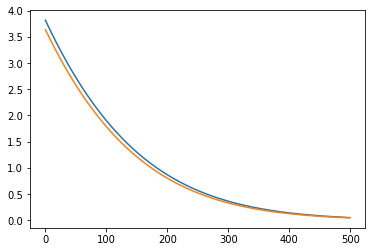

In [30]:
plt.plot(R1[0])
plt.plot(sigmMb1[0])
plt.show()

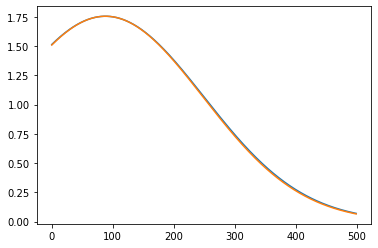

In [31]:
plt.plot(R2[0])
plt.plot(sigmMb2[0])
plt.show()

In [46]:
Cmvinv[1,1]

9.5425

In [37]:
np.linalg.inv([Cmv[0,0]])

LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

In [36]:
[Cmv[0,0]]

[0.45880478169060007]

In [24]:
Kd=1/((np.linalg.det(Cd))*(2*np.pi)**(Nm))**(0.5)
Km=1/((np.linalg.det(Cm))*(2*np.pi)**(Nm))**(0.5)
print(likelihood(0.2,0.3,G,d,Cdinv,Kd))

[-9.9303908]


In [26]:
Km=1/((np.linalg.det(Cm))*(2*np.pi)**(Nm))**(0.5)
print(apriori(0.2,0.3,m0,Cminv,Km))

[-4.61452829]


In [30]:
print(posterior(0.2,0.3,G,d,m0,Cdinv,Cminv,Kd,Km))

[-14.54491909]


In [31]:
#Se define una propuesta inicial [parámetro 1, parámetro 2]
p0=[0.5,0.5]
#La propuesta se convierte de una lista a un objeto numpy array
p0=np.array(p0)
#Se define un número de repeticiondes del MCMC
Nc=5*(10**5)
#Se define un arreglo para los datos generados con el muestreo
MCMC=np.zeros([Nc, len(p0)]) 
#Se define un arreglo para las muestras de la posterior
ln_probs = np.zeros(Nc) 
#Se define la primer muestra de la posterior a partir de la primer propuesta para los parámetros
ln_probs[0]=posterior(p0[0],p0[1],G,d,m0,Cdinv,Cminv,Kd,Km)

#Se asigna la primer propuesta el primer elemento de la cadena 
MCMC[0]=p0  

#Se toma un tiempo de inicio para medir el tiempo de ejecución con el método MCMC 
start_MCMC=time.perf_counter()
    
#Cíclo que realiza el MCMC
for i in range(1,Nc):
    #Se calculan las perturbaciones para los parámetros extraidas de distribuciones normales truncadas a manera de obtener únicamente muestras dentro del espacio paramétrico.    
    pertm1=truncnorm.rvs(-(MCMC[i-1,0]-a1),b1-MCMC[i-1,0],loc=0, scale=1) 
    pertm2=truncnorm.rvs(-(MCMC[i-1,1]-a2),b2-MCMC[i-1,1],loc=0, scale=1) 
    #Las perturbaciones para ambos parámetros se introducen en un arreglo numpy
    pert=np.array([pertm1,pertm2])
    #Se perturban los parámetros
    propuesta=MCMC[i-1]+pert
    #Se obtiene la distribución posterior de los parámetros perturbados
    #Newlnprob=np.log(Kb*np.exp(-0.5*np.matmul(np.matmul(np.transpose(np.array([[propuesta[0]],[propuesta[1]]])-mv),Cmvinv),(np.array([[propuesta[0]],[propuesta[1]]])-mv))))
    Newlnprob=posterior(propuesta[0],propuesta[1],G,d,m0,Cdinv,Cminv,Kd,Km)
    #Se obtiene la relación entre los parámetros perturbados y los de la iteración anterior
    Ratiolnprob=Newlnprob-ln_probs[i-1]
    #Criterio de metrópolis
    if (Ratiolnprob > 0) or (Ratiolnprob > np.log(np.random.uniform())):
        MCMC[i] = propuesta
        ln_probs[i] = Newlnprob
    else:
        MCMC[i]=MCMC[i-1]
        ln_probs[i]=ln_probs[i-1]

#Se toma el tiempo final para medir el tiempo de ejecución con el método MCMC 
end_MCMC=time.perf_counter()

In [32]:
print("Tiempo de ejecución MCMC:",end_MCMC-start_MCMC)

Tiempo de ejecución MCMC: 320.19436828099424


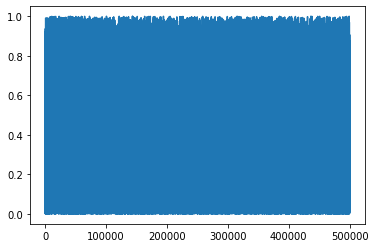

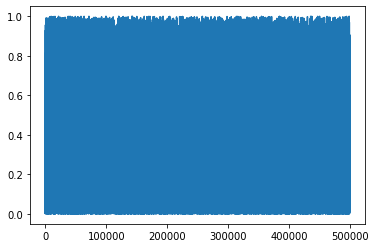

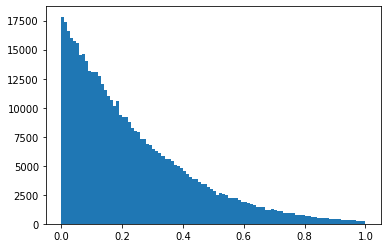

In [33]:
plt.plot(MCMC[:,0],label="Muestras de la cadena")
plt.show()


MCMC1=MCMC[1000:]

plt.plot(MCMC1[:,0],label="Muestras de la cadena")
plt.show()

plt.hist(MCMC1[:,0],bins=100)
plt.show()

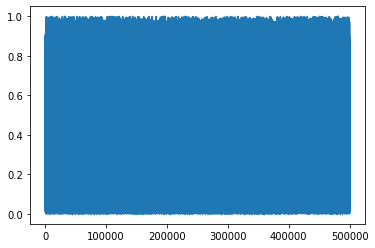

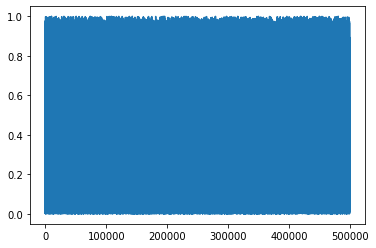

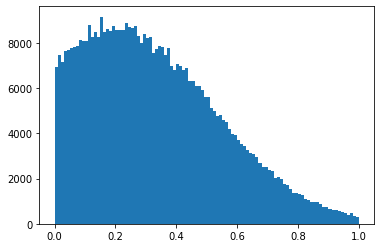

In [34]:
plt.plot(MCMC[:,1],label="Muestras de la cadena")
plt.show()


MCMC1=MCMC[1000:]

plt.plot(MCMC1[:,1],label="Muestras de la cadena")
plt.show()


plt.hist(MCMC1[:,1],bins=100)
plt.show()

In [35]:
#
m1d=np.arange(np.min(MCMC1[:,0]),np.max(MCMC1[:,0]),0.05)
#
m2d=np.arange(np.min(MCMC1[:,1]),np.max(MCMC1[:,1]),0.05)
M1d,M2d=np.meshgrid(m1d, m2d)

In [36]:
SigmaMCMC=np.zeros((len(m1d),len(m2d)))

for i in range(0,len(m1d)-1):
    for j in range(0,len(m2d)-1):
        for k in range(0,len(MCMC[:,1])):
            if (MCMC[k,0]>=m1d[i] and MCMC[k,0]<m1d[i+1] and MCMC[k,1]>=m2d[j] and MCMC[k,1]<m2d[j+1]):
                SigmaMCMC[i,j]=SigmaMCMC[i,j]+1
                np.delete(MCMC, k, axis=0)

In [39]:
dA=((m1d[1]-m1d[0])*(m2d[1]-m2d[0]))
dl1=m1d[1]-m1d[0]
dl2=m2d[1]-m2d[0]
SigmaMCMC=SigmaMCMC*dA
norm_factor=np.sum(SigmaMCMC)
SigmaMCMC=SigmaMCMC/norm_factor/dA
print(np.sum(SigmaMCMC)*dA)

0.9999999999999999


In [40]:
SigMarg1=np.sum((SigmaMCMC)*dl2,axis=1)
print(np.sum(SigMarg1*dl1))

SigMarg2=np.sum((SigmaMCMC)*dl1,axis=0)
print(np.sum(SigMarg2*dl2))

1.0
0.9999999999999999


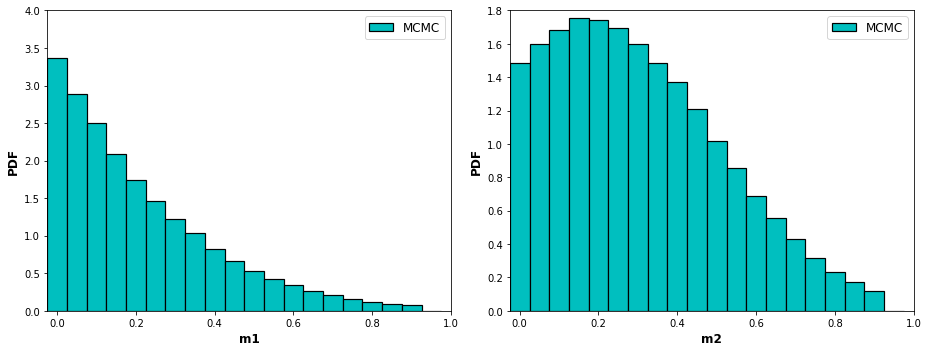

In [41]:
fig, axs = plt.subplots(1, 2,figsize=(13, 5))
axs[0].bar(m1d,SigMarg1,width=0.05,edgecolor="k",color="c",linewidth=1.2,label="MCMC")
#axs[0].plot(m1,sigmMb1[0],color="r",label="Aprox. α=8",linewidth=3)

axs[0].set_xlim([-0.025,1])
axs[0].set_ylim([0,4])
axs[0].set_ylabel("PDF",fontsize=12,fontweight=600)
axs[0].set_xlabel("m1",fontsize=12,fontweight=600)
axs[0].legend(prop={'size': 12})
#axs[0].set_title("PDF posterior, α="+str(alpha),fontsize=14,fontweight=600)


axs[1].bar(m2d,SigMarg2,width=0.05,edgecolor="k",color="c",linewidth=1.2,label="MCMC")
#axs[1].plot(m2,sigmMb2[0],color="r",label="Aprox. α=8",linewidth=3)
axs[1].set_xlim([-0.025,1])
axs[1].set_ylim([0,1.8])
axs[1].set_ylabel("PDF",fontsize=12,fontweight=600)
axs[1].set_xlabel("m2",fontsize=12,fontweight=600)
axs[1].legend(prop={'size': 12})
#axs[1].set_title("PDF posterior MCMC (sin normalizar)",fontsize=14,fontweight=550)
#axs[2].plot(names, values)
#fig.suptitle('Categorical Plotting')
plt.tight_layout()
#plt.savefig("PDF_marg_sintetico.png",dpi=400,bbox_inches='tight')
plt.show()


[]

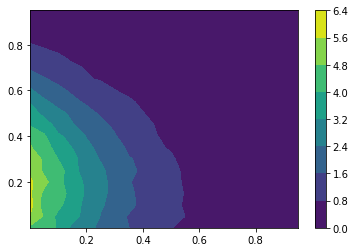

In [28]:
plt.contourf(M1d,M2d,np.transpose(SigmaMCMC))
plt.colorbar()
plt.plot()

[]

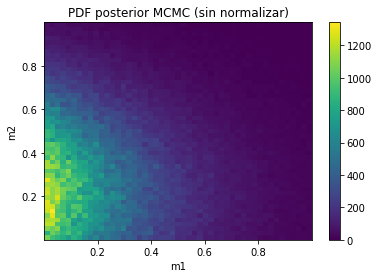

In [29]:
m1_bins = np.linspace(np.min(MCMC[:,0]), np.max(MCMC[:,0]), 50) 
m2_bins = np.linspace(np.min(MCMC[:,1]), np.max(MCMC[:,1]), 50) 

plt.hist2d(MCMC[:,0], MCMC[:,1],bins =[m1_bins, m2_bins]) 
plt.colorbar()
plt.xlabel("m1")
plt.ylabel("m2")
plt.title("PDF posterior MCMC (sin normalizar)")
plt.plot()

In [30]:
np.sum(SigmaMCMC*dA)

0.9999999999999999

1.0
0.9999999999999998


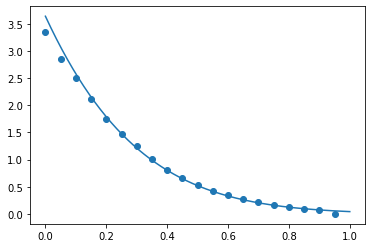

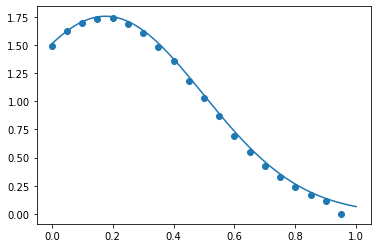

In [31]:
SigMarg1=np.sum((SigmaMCMC)*dl2,axis=1)
print(np.sum(SigMarg1*dl1))

SigMarg2=np.sum((SigmaMCMC)*dl1,axis=0)
print(np.sum(SigMarg2*dl2))



#Marginal parámetro m1
plt.scatter(m1d,SigMarg1)
#plt.bar(np.linspace(0,1,20),SigMarg1,width=1,edgecolor="k")
#plt.scatter(m1d,M)
#plt.show()
plt.plot(m1,sigmMb1[0])
#plt.xlim(0,1)
#plt.ylim(0,4)
plt.show()

plt.scatter(m2d,SigMarg2)
plt.plot(m2,sigmMb2[0])
#plt.xlim(0,1)
#plt.ylim(0,1.8)
#plt.xlim(0,1)
#plt.ylim(0,4)

plt.show()

In [34]:
#Estadísticas MCMC
#para m1
print("            m1","                 m2")
print("Media",np.mean(MCMC1[:,0]),"/",np.mean(MCMC1[:,1]))
#Para m2
print("std  ",np.std(MCMC1[:,0]),"/",np.std(MCMC1[:,1]))

            m1                  m2
Media 0.23446743656517388 / 0.3317218362681765
std   0.1998280291079767 / 0.2173037361264559


In [35]:
#Estadísticas Nocquet

print("            m1","                 m2")
print("Media",TNmean(a1,b1,mv[0],(Cmv[0,0])**(0.5)),"/",TNmean(a2,b2,mv[1],(Cmv[1,1])**(0.5)))
#Para m2
print("std  ",(TNvar(a1,b1,mv[0],(Cmv[0,0])**(0.5)))**(0.5),"/",(TNvar(a1,b1,mv[1],(Cmv[1,1])**(0.5)))**(0.5))

            m1                  m2
Media 0.23323502832557985 / 0.38460143996929175
std   0.2021553344891798 / 0.23423831009992402


In [ ]:
TNmean()

In [26]:
#Funcion que calcula la expectatica y la matriz de covarianza posterior de una distribución de probabilidad normal
def mvCmv(G,d,Cdinv,alpha,limsup,m0):
    
    GT=np.transpose(G)
    #Se define la desviación estandar (pp 373, primer párrafo, quinto renglón)
    sigma=alpha*(limsup/2)
    #Se define la matriz de covarianza de los parámetros (pp) (pp 372, primer parrafo, segundo renglón)
    Cm=np.identity(Nm)*((sigma.reshape(Nm,1))**2)
    #Se define la inversa la matriz de covarianza de los parámetros
    Cminv=np.linalg.inv(Cm)
    #Se define la matriz de covarianza posterior (Ecuaciones de Tarantola y Valette, pp. 369, Ec. 7)
    Cmv=np.linalg.inv(np.matmul(np.matmul(GT,Cdinv),G)+Cminv)
    #Se define la transpuesta de la matriz de covarianza posterior
    CmvT=np.transpose(Cmv)
    #Se define la inversa de la matriz de covarianza posterior
    Cmvinv=np.matmul(np.matmul(GT,Cdinv),G)+Cminv
    #Se define la expectativa (Ecuaciones de Tarantola y Valette, pp. 369, Ec. 6)
    mv=np.matmul(np.linalg.inv(np.matmul(np.matmul(GT,Cdinv),G)+Cminv), np.matmul(np.matmul(GT,Cdinv),d)+np.matmul(Cminv,m0))
    return mv, Cmv

In [29]:
alpha=np.ones(Nm)*0.1
alphar=np.zeros(Nm)
vr=np.zeros(Nm)
vraux=np.zeros(Nm)
cont=0

limsup=1
m0=np.array([[limsup/2],[limsup/2]])

for i in range(0, 100): #Este ciclo es para ir incrementando el valor de alpha
    mvaux,Cmvaux=mvCmv(G,d,Cdinv,alpha,limsup,m0)
    for j in range(0,Nm): #Este ciclo es para recorrer cada parámetro 
        sigprior=alpha[j]*(limsup/2)
        #vr=(prior-posterior)/prior
        vraux[j]=((sigprior**2)-Cmvaux[j,j])/(sigprior**2)
        if ((vraux[j]-vr[j])>0.001):
        #if (vraux[j]>vr[j]): #Se revisa si vr incrementó
            alphar[j]=alpha[j]
            cont=cont+1
    #print(cont)
    print(i)
    print(vr[1]-vraux[1])
    #print(vraux)
    if (cont==0):
        break
    cont=0 #Se reinicia el contador que indica las veces que un parámetro mejoró 
    vr=np.copy(vraux) #Se actualizan los valores vr
    alpha=alpha+0.1 #Se incrementa el valor de alpha para la siguiente prueba

0
-0.02314888413852047
1
-0.06340882180945524
2
-0.08910947339406455
3
-0.0989575484552804
4
-0.09687543486508216
5
-0.08808263960455498
6
-0.07668984084571806
7
-0.06516336258039135
8
-0.05468680188109809
9
-0.045670306557742735
10
-0.03813095785389986
11
-0.03191842532476763
12
-0.0268316238830687
13
-0.022672225513425404
14
-0.019265444962108136
15
-0.016465290490248807
16
-0.014153160177824642
17
-0.012234074572211484
18
-0.010632478236290654
19
-0.00928839221360478
20
-0.008154165810793867
21
-0.007191845120751328
22
-0.006371087728049507
23
-0.005667529486944267
24
-0.0050615125564381636
25
-0.00453709663426527
26
-0.004081289919474096
27
-0.00368344970907164
28
-0.0033348137404769496
29
-0.003028132361290292
30
-0.002757378608763461
31
-0.0025175186683061845
32
-0.0023043292932599657
33
-0.002114251896563446
34
-0.0019442754018303976
35
-0.0017918417484366067
36
-0.001654769321621119
37
-0.001531190629797008
38
-0.0014195013566828951
39
-0.0013183185352284577
40
-0.0012264460684

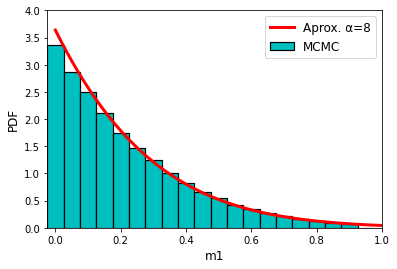

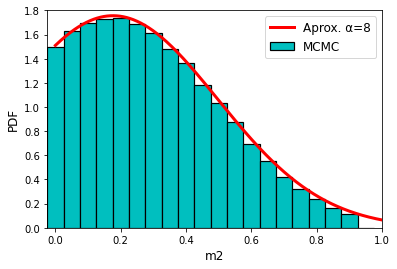

In [122]:
#plt.subplot(1,2,1)
#Marginal parámetro m1
#plt.scatter(m1d,SigMarg1)
#plt.bar(np.linspace(0,1,20),SigMarg1,width=1,edgecolor="k")
plt.bar(m1d,SigMarg1,width=0.05,edgecolor="k",color="c",linewidth=1.2,label="MCMC")
#plt.scatter(m1d,M)
#plt.show()
plt.plot(m1,sigmMb1[0],color="r",label="Aprox. α=8",linewidth=3)
plt.xlim(-0.025,1)
plt.ylim(0,4)
plt.xlabel("m1",fontsize=12)
plt.ylabel("PDF",fontsize=12)
plt.legend(prop={'size': 12})
plt.show()

#plt.subplot(1,2,2)

#plt.scatter(m2d,SigMarg2)
plt.bar(m2d,SigMarg2,width=0.05,edgecolor="k",color="c",linewidth=1.2,label="MCMC")
plt.plot(m2,sigmMb2[0],color="r",label="Aprox. α=8",linewidth=3)
#plt.xlim(0,1)
plt.ylim(0,1.8)
plt.xlim(-0.025,1)
plt.xlabel("m2",fontsize=12)
plt.ylabel("PDF",fontsize=12)
#plt.ylim(0,4)
plt.legend(prop={'size': 12})
plt.show()

In [75]:
m=np.zeros((len(m1),Nm))+m1.reshape(len(m1),1)
xmar=np.linspace(0,1,500)
R1=PDFmarginal(xmar,m,Cmv,mv,Kb,[1])
R2=PDFmarginal(xmar,m,Cmv,mv,Kb,[0])
#R1
#plt.plot(R1[0])
#plt.show()

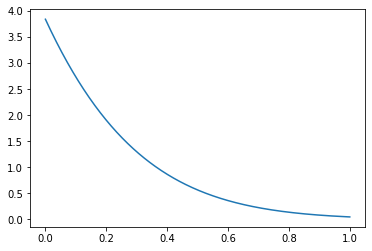

In [141]:
m=np.zeros((len(m1),Nm))+m1.reshape(len(m1),1)
Sig1D=marginal(m,Cmv,mv,Kb,[1])

plt.plot(m1,Sig1D[0])
plt.show()